In [9]:
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env")

True

### Nodes & Edges

In [32]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END,MessageGraph
import time

In [33]:
def add_one(input: list[HumanMessage]):
    input[0].content=input[0].content + 'a'
    time.sleep(1)
    return input


In [34]:
graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

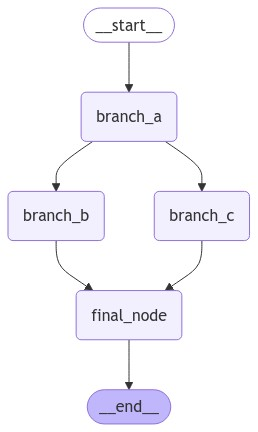

In [17]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [35]:
runnable.invoke("b")


[HumanMessage(content='baaaa', additional_kwargs={}, response_metadata={}, id='5954d830-98e1-48cc-adfe-b5e437639f5d')]

In [36]:
runnable.invoke("a")


[HumanMessage(content='aaaaa', additional_kwargs={}, response_metadata={}, id='1c53b5b6-808d-4136-8aa0-d9bbfae4a640')]

### Conditional Edges


In [37]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


In [38]:
def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return input


def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"

In [39]:
graph = MessageGraph()


In [40]:
graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

In [41]:
graph.add_conditional_edges(
    "branch_a", router, {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")


In [42]:
runnable = graph.compile()

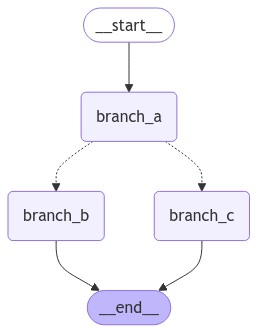

In [43]:
display(Image(runnable.get_graph().draw_mermaid_png()))


In [44]:
runnable.invoke("hello")


Using branch C


[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='efc73f62-6d42-4fef-8c61-695c16d0de0d')]

In [45]:
runnable.invoke("I want to use_b")


Using branch B


[HumanMessage(content='I want to use_b', additional_kwargs={}, response_metadata={}, id='21108178-bcba-499c-b4d8-2d709e1e40d6')]

### Cycles

In [46]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph
from langchain_openai import AzureChatOpenAI
import os
#model = ChatOpenAI(temperature=0)
model = AzureChatOpenAI(azure_deployment="gpt-4o-mini-2024-07-18",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version=os.getenv("AZURE_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    )




In [47]:
def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


In [48]:
graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent", should_continue, {"action": "action", "__end__": END}
)

In [49]:
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()

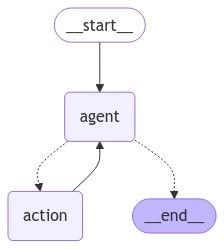

In [50]:
display(Image(runnable.get_graph().draw_mermaid_png()))


In [51]:
runnable.invoke("Hello")


Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='88cc9e1c-20ec-43a2-a1b7-255beb97e28d'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='4a96d653-de20-440e-a264-b153fe102c72'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='29ba6e9b-0d8d-4e68-b0de-dcc3389a4f02'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='2c83052d-d7f8-459f-8ba6-bff88a631b6e'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='c06635ca-9d5c-4cfe-a6f8-07a4cd2dde97'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='699cd951-ed4b-4cd0-a7b3-4be443750aaa'),
 HumanMessage(content='end', additional_kwargs={}, response_metadata={}, id='8a9148ad-05ed-4214-aa55-5e54265ec951')]